Welcome to Jaxon AutoSpec! To talk to Jaxon, start a code cell with `:` and type your message.

# Pigeonhole Principle Application in Participation Distribution
### Pigeonhole Principle Application:

 The pigeonhole principle is a fundamental concept in combinatorics and mathematics.
 It basically states that if you have more items than containers, at least one
 container must hold more than one item. It's named after the idea that if you have
 more pigeons than pigeonholes, at least one pigeonhole must contain more than one
 pigeon.

 In a scenario where the number of items (pigeons) is equal to the number of
 containers (pigeonholes), the pigeonhole principle might not seem directly
 applicable in the traditional sense. However, we can still use it to
 understand the distribution of selections:

 1. **Equal Stake:**
    If each group member had an equal stake (each stake weight
    is ($1/n$), the expected number of selections for each member would
    be roughly equal across multiple selections.

 2. **Different Stake:**
    When the stake weights vary, some members have higher probabilities of
    being selected. In this case, the pigeonhole principle tells us that
    certain members (those with larger weights) are more likely to be
    selected multiple times, while others (those with smaller weights) are
    less likely to be selected.

### Intuition:

 - With **replacement** and **different stake weights**, the principle
   suggests that members with smaller weights indeed have a lower
   probability of being selected multiple times (or even at all, especially
   if the selection rounds are relatively few compared to the number of
   members).
 - For instance, if one member has a very small stake weight, it becomes
   statistically likely that they will be overshadowed by members with
   larger stake weights.

### Hypothesis:
 Using the pigeonhole principle, it’s expected that some group members with smaller
 stake weights may not (ever?) get selected for committee seats.

### Experiment Design:
 The experiment aims to understand the distribution of selections in a committee
 when the selection size is equal to the group size. The pigeonhole principle
 helps us interpret the results and understand the uneven distribution of
 selections based on stake weights.

#### Given:
 - Participant Group size ($n$), randomly selected from population
 - Committee size ($k$)
 - Random selection of committee with replacement per stake weight
 - Stake weight of each group member sums to 1

#### Procedure:
 1. **Sample Group:**
    - Sample $n$ participants *without replacement* from the population
      with uniform probability distribution (all groups are equally likely).
    - Calculate the stake weight for each participant normalized to sum to 1.
 2. **Assign Committee:**
    - Perform Monte Carlo simulation of committee selection by sampling
      *with replacement* for a number of iterations.
    - For each iteration, select a committee of size based on the
      normalized stake weight of each participant.
    - Count the number of times each participant is selected for a committee
      seat.
 3. **Analyze Committee Selection and Seat Counts:**
    - Sort the committee seat count in descending order.
    - Identify the index where the seat counts first goes to zero.
    - Visualize the results through graphic plots.

#### Results:

 As expected for any group of particplants, members with smaller stake weight
 are less likely get selected.
 This is a natural outcome of the selection process, especially when the committee
 size ($k$) and the group size ($n$) are the same, but this is equality is not
 assumed. The pigeon hole principle shows that the distribution is uneven, leading
 to such outcomes. The probabilitiy of selection is near zero in the short term;
 however, with repeated trials, there is a nonzero probability, almost surely,
 that each participant will get a committee seat, eventually.


In [ ]:
# %%

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data import load_data


def sample_group(
    population: pd.DataFrame,
    group_size: int = 300,
) -> pd.DataFrame:
    """
    Uniformly sample from a population of participlants without replacement.
    Only samples groups with nonzero stake is returned.

    Args:
    - population: DataFrame containing the population.
    - group_size: Number of samples to draw.

    Returns:
    - sample: DataFrame of sample of size `group_size` (n).

    """
    sample = population[population.stake > 0].sample(
        group_size,
        replace=False,
    )
    sample["stake_weight"] = sample.stake / sample.stake.sum()
    # Sort by stake weight in descending order
    sample = sample.sort_values("stake_weight", ascending=False)
    return sample


def get_stake_distribution(
    population: pd.DataFrame,
    group_size: int = 300,
    num_iter: int = 1,
    plot_it: bool = True,
    figsize: tuple[int, int] = (12, 6),
) -> pd.DataFrame:
    """ """
    # Let's collect the sample participants.stake.values for every participant
    # in the given sample group size. Average them if num_iter > 1.

    # Initialize an array to store the sum of stakes for each participant
    stakes = np.zeros(group_size)
    for n in range(num_iter):
        participants = sample_group(population, group_size)
        # Add the stakes of the current iteration to the stake_sums array
        stakes += participants.stake.values

    if num_iter > 1:
        # Calculate the average stakes
        stakes = pd.DataFrame(stakes / num_iter, columns=["stake"])
    else:
        stakes = pd.DataFrame(stakes, columns=["stake"])

    min_stake = stakes.stake.min()
    max_stake = stakes.stake.max()

    if plot_it:
        # Plot the stake for each participant number 1 to group_size
        plt.figure(figsize=figsize)
        plt.plot(
            stakes.stake.values,
            marker=".",
            linestyle="-",
            alpha=1,
            color="red",  # Color for the average curve
            linewidth=2,
            markersize=3,
            label="Average Stake",
        )

        # Draw a horizontal line at maximum stake value
        plt.axhline(
            y=max_stake,
            color="blue",
            linestyle="--",
            alpha=0.6,
            label=f"Max. Stake = {max_stake}",
        )

        # Draw a horizontal line at minimum stake value
        plt.axhline(
            y=min_stake,
            color="green",
            linestyle="--",
            alpha=0.6,
            label=f"Min. Stake = {min_stake}",
        )

        plt.legend()
        plt.title(f"Stake for each Participant (1 to {group_size})")
        plt.xlabel("Participant Number")
        plt.ylabel("Stake")
        plt.show()

    # Add the stake weight column to the DataFrame
    stakes["stake_weight"] = stakes.stake / stakes.stake.sum()

    return stakes


def assign_commitee(
    group: pd.DataFrame,
    committee_size: int = 300,
    alpha: float = 0.0,
    num_iter: int = 1000,
    figsize: tuple[int, int] = (12, 6),
) -> pd.DataFrame:
    """
    Assumes participants in a given group of size group_size are assigned to
    a committee using random selection with replacement based on their stake
    weight. The committee has a fixed size equal to the group_size. As such,
    partipants with larger stake-weight will occupy multiple committee seats.
    We perform Monte Carlo simulation of multiplle committee selections, thus
    repeated for the given number of iterations.

    Args:
    - group: DataFrame containing the group of participants, assumed size n.
    - committee_size: Size of the committee (k).
    - alpha: Probability of uniform random sampling in a mixture model.
    - num_iter: Number of iterations for Monte Carlo simulation.
    - figsize: Size of the figure.

    Returns:
    - participant_counts: DataFrame of the committee seats per participant.

    """
    group_size = group.shape[0]  # size n

    # Initialize an array to store the number of
    # committee seats per participant
    seat_counts = pd.Series(
        np.zeros(group_size, dtype="int64"),
        name="count",
    )

    for n in range(num_iter):
        #
        # Select a committee based on the stake weight of each
        # participant stake holder.
        #
        committee = group.sample(
            n=committee_size,
            weights="stake_weight",
            replace=True,
        )

        # Count the number of times each participant is selected
        # for a committee seat
        participant_counts = committee.index.value_counts()

        # Reindex participant_counts to match sum_counts index
        # and fill missing values with 0
        participant_counts = participant_counts.reindex(
            seat_counts.index,
            fill_value=0,
        )

        # Add the counts to the sum_counts array
        seat_counts += participant_counts

    # Sort the sum_counts in descending order
    seat_counts.sort_values(ascending=False, inplace=True)
    # Get the index of sum_counts where the value is first zero
    first_zero_index = group.index[: -seat_counts[seat_counts == 0.0].shape[0]].max()

    # Let's plot both group and sum_counts with two y-axes,
    # one for each
    fig, ax1 = plt.subplots(figsize=figsize)
    ax2 = ax1.twinx()
    ax1.plot(group.stake.values, color="red", label="Group Stake")
    ax2.plot(seat_counts.values, color="blue", label="Committee Seats")
    ax1.set_ylabel("Stake")
    ax2.set_ylabel("Committee Seats (count)")
    ax1.set_xlabel("Participant Index")
    ax1.legend(loc="upper center")
    ax2.legend(loc="upper right")
    plt.title(
        "Participant Seat Count in"
        f" Committee of Size k = {committee_size}"
        f"\nfrom Group of Size n = {group_size}"
    )
    plt.axhline(y=0, color="gray", linestyle="--", alpha=0.6)
    # Draw vertical line where the committee seat count first goes to zero
    plt.axvline(x=first_zero_index, color="green", linestyle="--")
    # Print the value of this first_zero_index along the center of the
    # vertical line
    plt.text(
        first_zero_index,
        ax2.get_ylim()[1] / 2.0,
        f"First Zero Index = {first_zero_index}",
        rotation=0,
        verticalalignment="center",
        horizontalalignment="center",
        color="green",
        backgroundcolor="white",
    )
    plt.show()

    return committee, seat_counts, first_zero_index


def plot_group_to_committee_index(
    seat_counts: pd.Series,
    figsize: tuple[int, int] = (6, 6),
):
    """
    A simple scatter plot of the two series indexes
    to see how they align.

    Args:
    - seat_counts: Series containing the committee seat counts
      indexed by participant index.
    - figsize: Size of the figure.

    """
    plt.figure(figsize=figsize)
    plt.scatter(
        np.arange(len(seat_counts)),
        seat_counts.index,
        marker=".",
        color="green",
    )
    plt.xlabel("Group Participant Index")
    plt.ylabel("Seat Selection Participant Index")
    plt.title("Seat Selection Index vs. Participant Index")
    plt.legend()
    plt.show()


# Plot the selection counts for each group size
def plot_committee_selection_counts(
    selection_counts: pd.DataFrame,
    first_zero_indices: np.ndarray,
    log_scale: bool = True,
    figsize: tuple[int, int] = (12, 6),
):
    """
    Plot the committee selection counts for varying group sizes.

    Args:
    - selection_counts: DataFrame containing the committee seat counts.
    - first_zero_indices: Array containing the first zero index for each group size.
    - log_scale: Boolean flag to set the y-axis to log scale.
    - figsize: Size of the figure.

    """
    plt.figure(figsize=figsize)
    selection_counts.plot(
        marker="",
        linestyle="-",
        linewidth=1,
        alpha=0.9,
    )
    for i, cutoff in enumerate(first_zero_indices):
        plt.axvline(
            x=cutoff,
            color=plt.gca().lines[i].get_color(),
            linestyle="--",
            linewidth=1,
            alpha=0.6,
        )
        # Print the value of this cutoff value along the center of the vertical line
        plt.text(
            cutoff,
            plt.gca().get_ylim()[1] / 2.0,
            f"{int(cutoff)}",
            rotation=0,
            verticalalignment="center",
            horizontalalignment="center",
            color=plt.gca().lines[i].get_color(),
            backgroundcolor="white",
            fontsize="medium",
        )
        if log_scale:
            plt.yscale("log")

    plt.legend(fontsize="small")
    plt.xlabel("Participant Index", fontsize="small")
    plt.ylabel("Committee Seats (count)", fontsize="small")
    plt.title(
        "Committee Participation Selected from Varying Group Sizes",
        fontsize="medium",
    )
    plt.show()


def plot_selection_count_vs_stake(
    group_stakes: pd.DataFrame,
    committee_seats: pd.DataFrame,
    first_zero_index: int,
    figsize: tuple[int, int] = (12, 6),
):
    """
    Plot the seat assignment count vs. stake for a committee
    of a given size.

    Args:
    - group_stakes: DataFrame containing the stake weight of each participant.
    - committee_seats: DataFrame containing the committee members.
    - first_zero_index: Index where the seat count first goes to zero.
    - figsize: Size of the figure.

    """
    committee_size = committee_seats.shape[0]
    group_size = group_stakes.shape[0]
    cutoff = group_stakes.loc[first_zero_index, "stake"]

    # Count the number of seats each participant has in the committee
    participant_counts = committee_seats.index.value_counts()
    assert participant_counts.index.is_unique

    # Align committee_members with participant_counts
    committee_members = group_stakes.loc[participant_counts.index].sort_values(
        by="stake", ascending=False
    )

    x = committee_members.stake.values
    y = participant_counts.values

    # Plot selection seat count vs. stake
    plt.figure(figsize=figsize)
    plt.plot(
        x,
        y,
        marker=".",
        linestyle="-",
        alpha=0.8,
    )
    plt.gca().invert_xaxis()
    plt.xlabel("Participant Stake")
    plt.ylabel("Participant Seats (count)")
    plt.title(
        "Participant Seat Count in"
        f" Committee of Size k = {committee_size}"
        f"\nfrom Group of Size n = {group_size}"
    )
    plt.axvline(
        x=cutoff,
        color="gray",
        linestyle="--",
        linewidth=1,
        alpha=0.6,
    )
    # Print the value of this cutoff value along the center of the vertical line
    plt.text(
        cutoff,
        plt.gca().get_ylim()[1] / 2.0,
        f"Cutoff stake = {int(cutoff)}",
        rotation=0,
        verticalalignment="center",
        horizontalalignment="right",
        color="black",
        backgroundcolor="white",
        fontsize="medium",
    )
    plt.show()

In [ ]:
# %%

# The population of registered SPOs

population = load_data("../../data/pooltool-cleaned.csv")
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3056 entries, 0 to 3055
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             3056 non-null   object 
 1   stake          3056 non-null   int64  
 2   stake_percent  3056 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 71.8+ KB


In [ ]:
# %%

population.describe()

,stake,stake_percent
count,3.056000e+03,3056.000000
mean,7.305314e+06,0.032723
std,1.648449e+07,0.073839
min,0.000000e+00,0.000000
25%,5.265000e+02,0.000002
50%,5.692500e+04,0.000255
75%,3.282500e+06,0.014703
max,1.054300e+08,0.472250


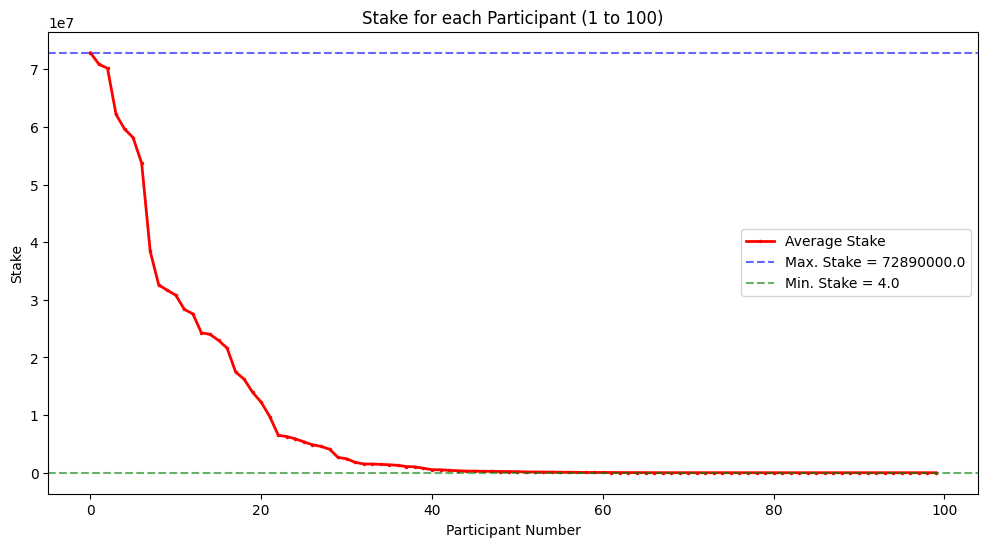

,stake,stake_weight
0,72890000.0,8.491243e-02
1,70890000.0,8.258255e-02
2,70190000.0,8.176709e-02
3,62190000.0,7.244758e-02
4,59640000.0,6.947698e-02
...,...,...
95,30.0,3.494818e-08
96,27.0,3.145336e-08
97,10.0,1.164939e-08
98,5.0,5.824697e-09


In [ ]:
# %%

# Let's now sample a group of participants from the population
# and calculate the stake weight for each participant.

group_size = 100

group_stakes = get_stake_distribution(
    population,
    group_size=100,
    num_iter=1,
)
group_stakes

In [ ]:
# %%

group_stakes.describe()

,stake,stake_weight
count,1.000000e+02,1.000000e+02
mean,8.584138e+06,1.000000e-02
std,1.770890e+07,2.062979e-02
min,4.000000e+00,4.659757e-09
25%,3.117500e+03,3.631698e-06
50%,1.955050e+05,2.277515e-04
75%,5.490000e+06,6.395517e-03
max,7.289000e+07,8.491243e-02


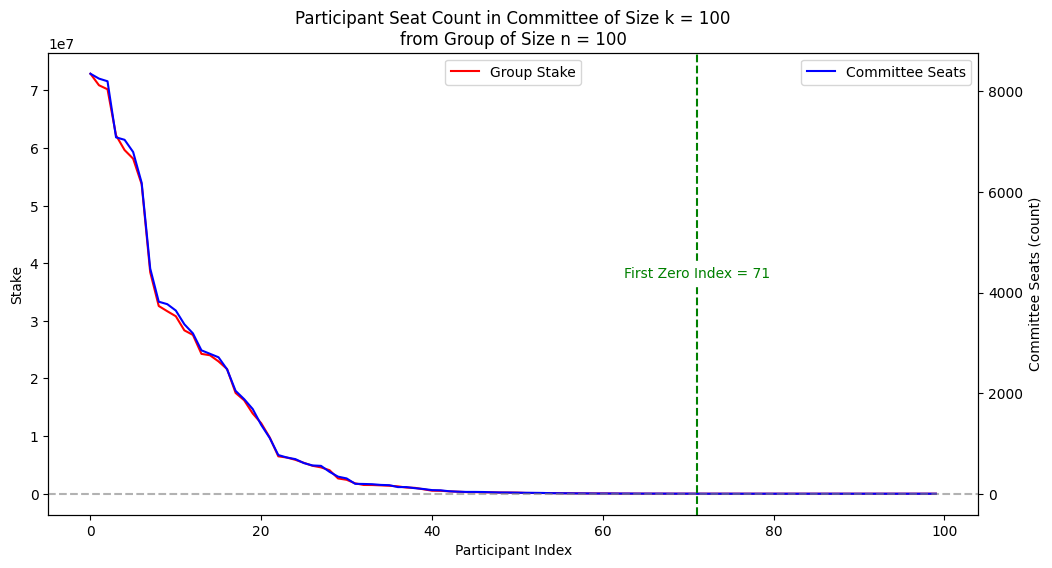

In [ ]:
# %%

# Let's now assign a committee of the fixed group_size
# based on the stake weight of each

committee, seat_counts, first_zero_index = assign_commitee(
    group_stakes,
    committee_size=group_size,
    num_iter=1000,
)

In [ ]:
# %%

print("Committee")  # Participants selected for the committee
print(committee)
print("\nSeat Counts")  # Number of times each participant is selected
print(seat_counts)
print("\nFirst Zero Index")  # Index where the seat count first goes to zero
print(first_zero_index)

Committee
         stake  stake_weight
18  16220000.0      0.018895
4   59640000.0      0.069477
1   70890000.0      0.082583
9   31670000.0      0.036894
19  13930000.0      0.016228
..         ...           ...
7   38440000.0      0.044780
19  13930000.0      0.016228
27   4570000.0      0.005324
16  21640000.0      0.025209
30   2420000.0      0.002819

[100 rows x 2 columns]

Seat Counts
0     8351
1     8254
2     8201
3     7086
4     7037
      ... 
72       0
71       0
70       0
66       0
99       0
Name: count, Length: 100, dtype: int64

First Zero Index
71


<ipython-input-15-c66b32bcb91f>:230: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


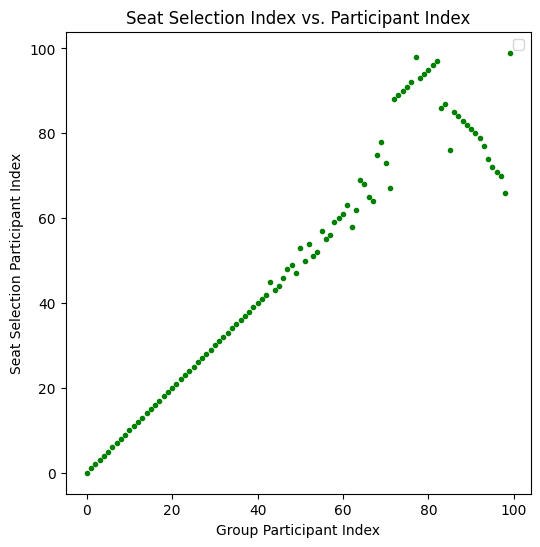

In [ ]:
# %%

plot_group_to_committee_index(seat_counts)

In [ ]:
# %%

# Let's now create a plots of committee assignments where we vary
# the group size over {100, 200, 300, 400, 500} and see how the
# committee selection and seat count changes.

# Initialize Parameters:
committee_size = 300  # k
group_sizes = [100, 200, 300, 400, 500]  # vary over group size, n
num_iter = 1000  # Number of iterations for Monte Carlo simulation

# Initialize an array to store the first zero index for each group size
first_zero_indices = np.zeros(len(group_sizes))

# Initialize a DataFrame to store the seat count for each group size
selection_counts = {}

Group Size: 100


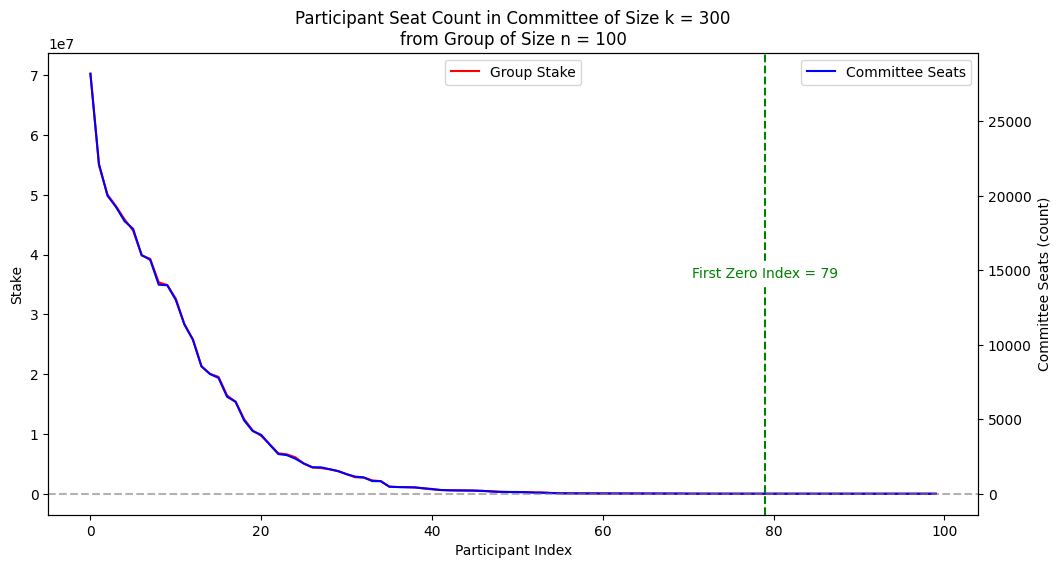

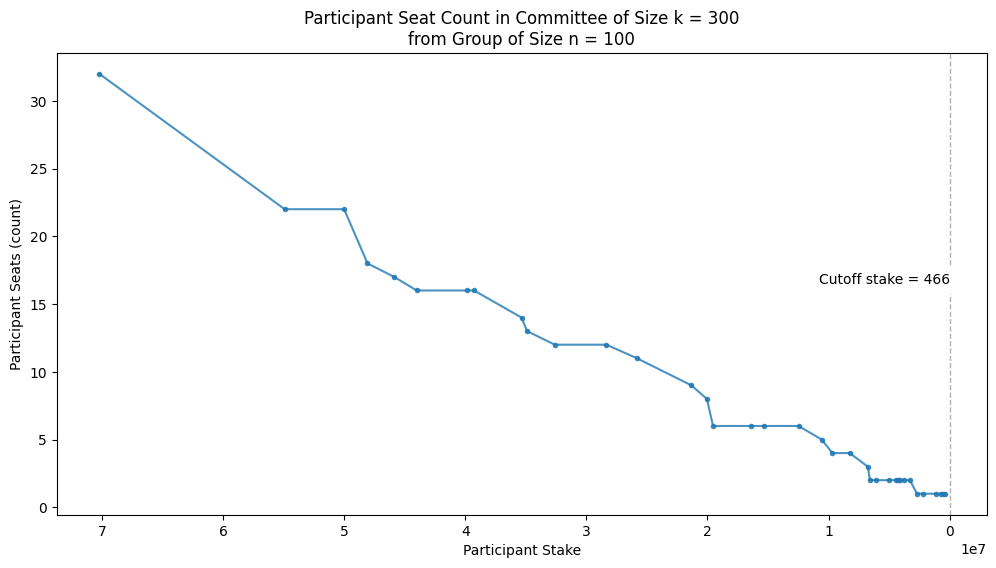

Group Size: 200


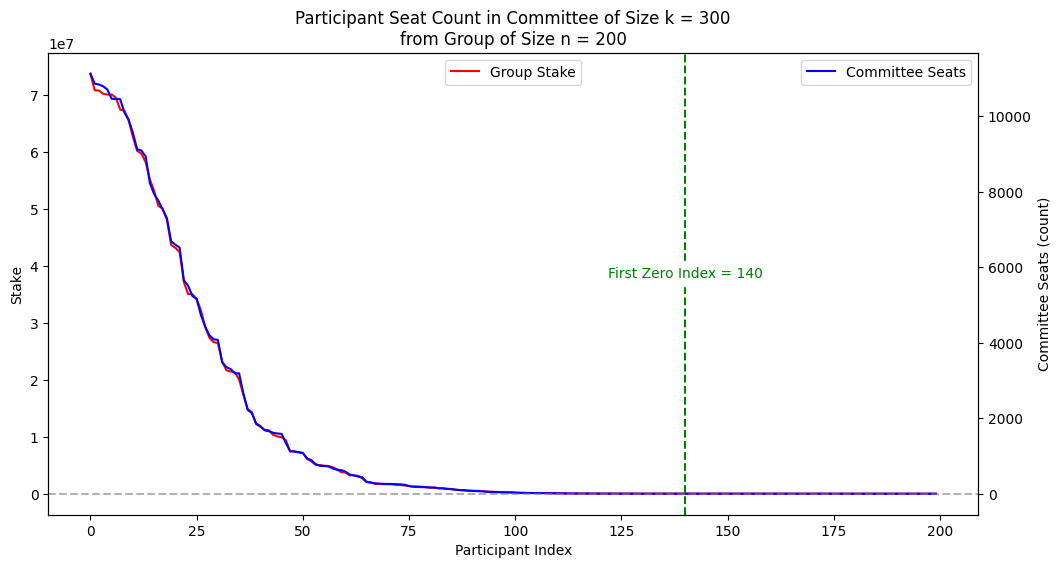

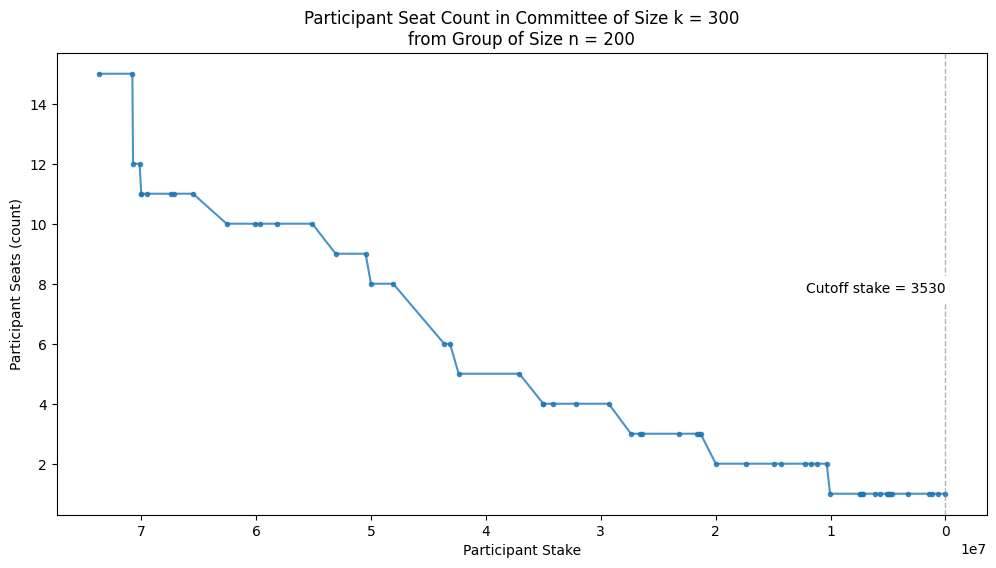

Group Size: 300


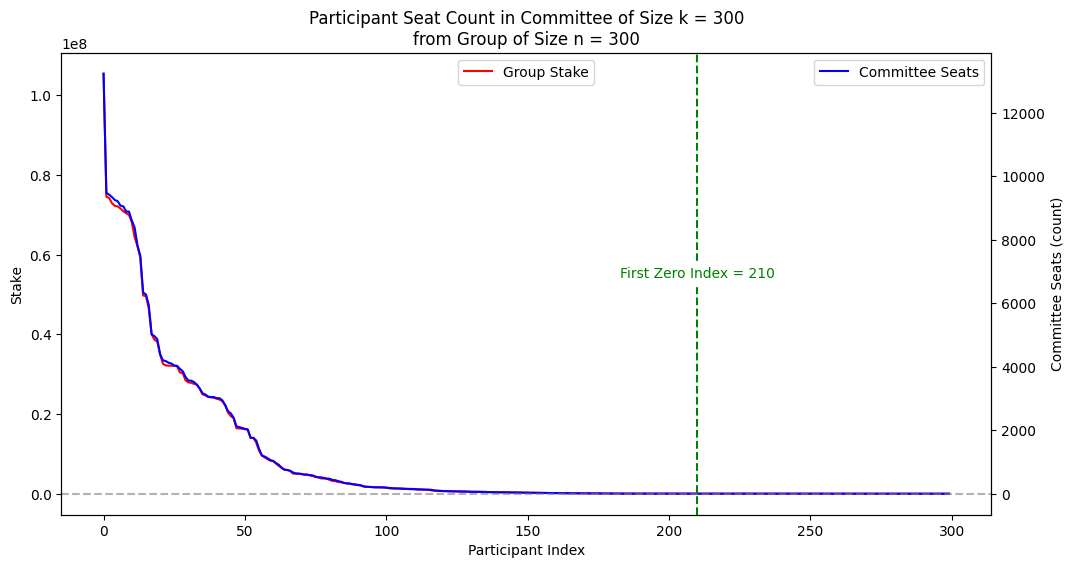

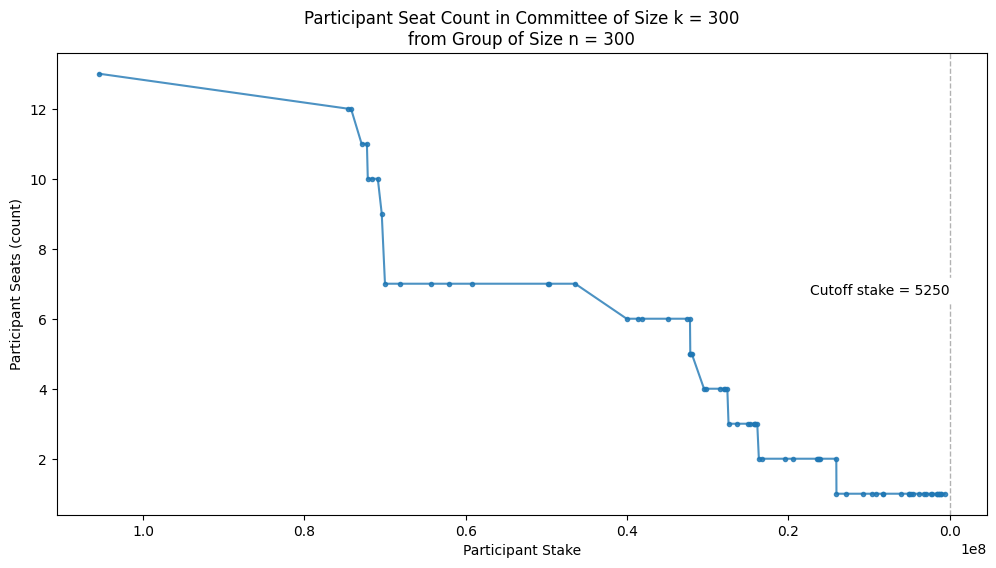

Group Size: 400


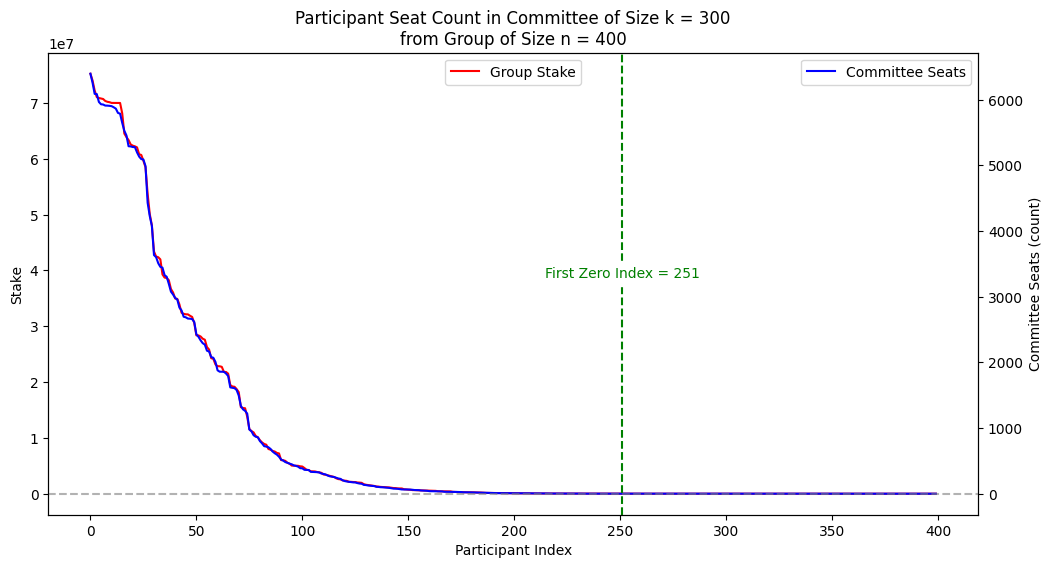

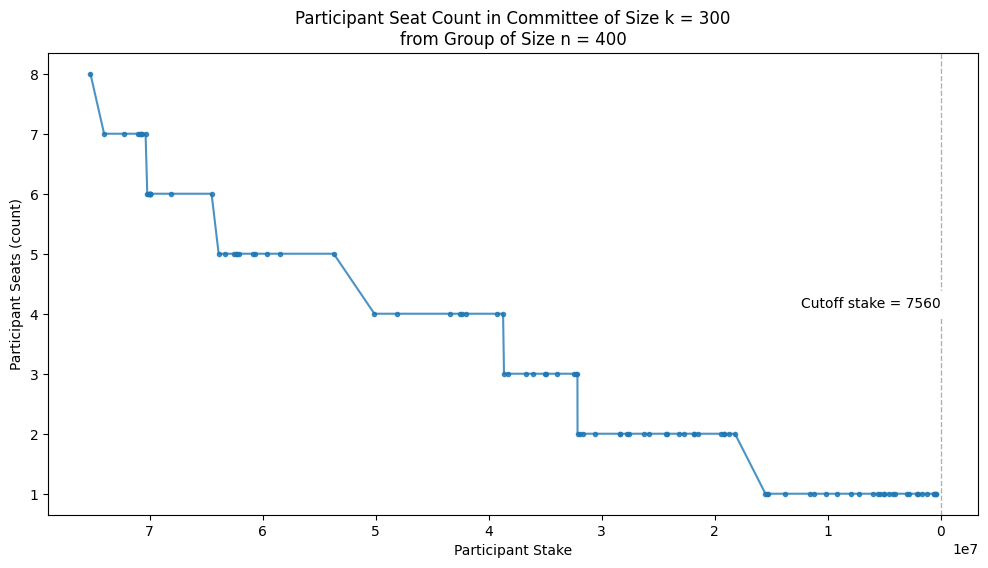

Group Size: 500


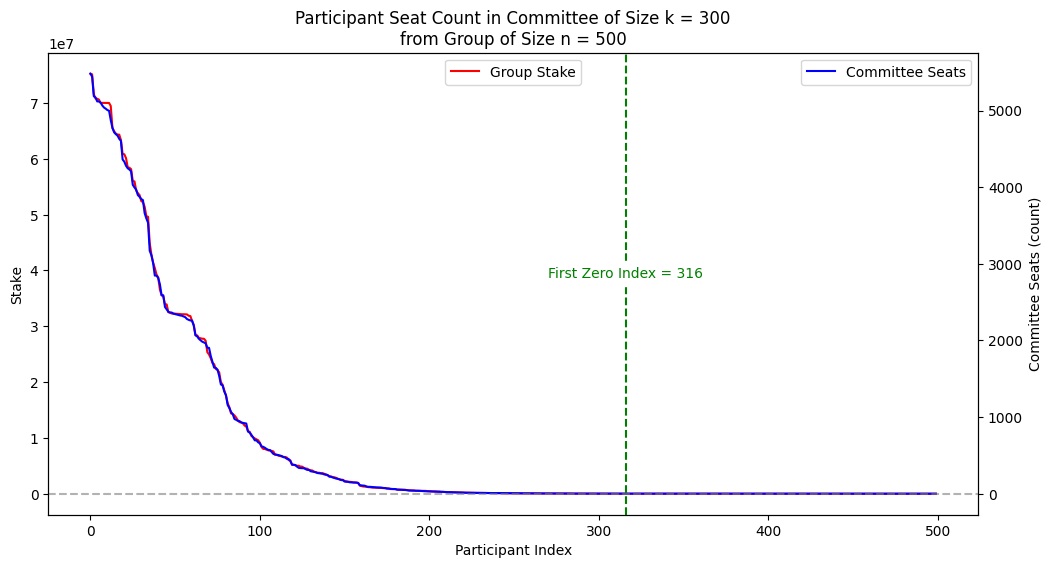

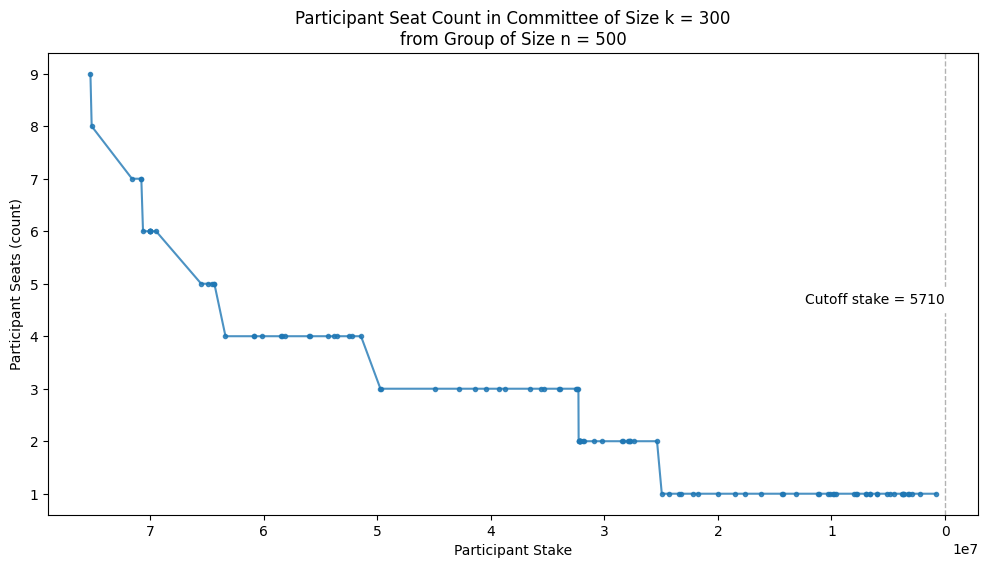

In [ ]:
# %%

# Loop over the group sizes
for i, group_size in enumerate(group_sizes):
    print(f"Group Size: {group_size}")
    group_stakes = get_stake_distribution(
        population,
        group_size,
        num_iter=1,
        plot_it=False,
    )
    committee, sum_counts, first_zero_index = assign_commitee(
        group_stakes,
        committee_size=committee_size,
        num_iter=num_iter,
    )
    first_zero_indices[i] = first_zero_index
    selection_counts[f"Group Size = {group_size}"] = sum_counts

    plot_selection_count_vs_stake(
        group_stakes,
        committee,
        first_zero_index,
    )

In [ ]:
# %%

# Collect the selection frequencies in a DataFrame
selection_counts = pd.DataFrame(selection_counts)

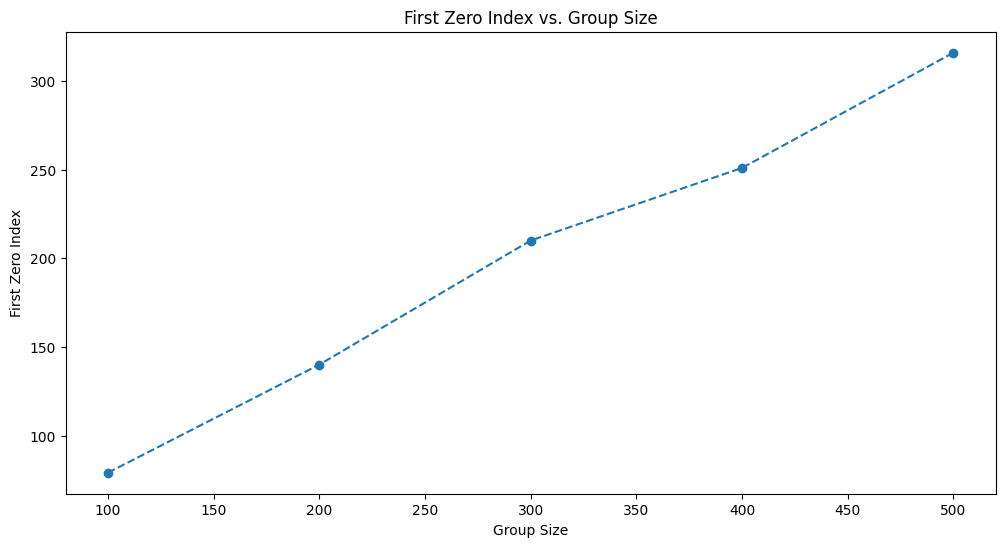

In [ ]:
# %%

# Plot the first zero index for each group size
plt.figure(figsize=(12, 6))
plt.plot(group_sizes, first_zero_indices, marker="o", linestyle="--")
plt.xlabel("Group Size")
plt.ylabel("First Zero Index")
plt.title("First Zero Index vs. Group Size")
plt.show()

<Figure size 1200x600 with 0 Axes>

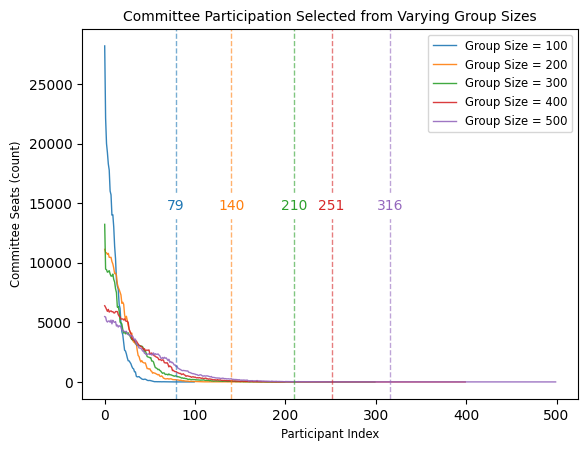

In [ ]:
# %%

# Plot the selection counts for each group size
log_scale = False
plot_committee_selection_counts(
    selection_counts,
    first_zero_indices,
    log_scale=log_scale,
)

<Figure size 1200x600 with 0 Axes>

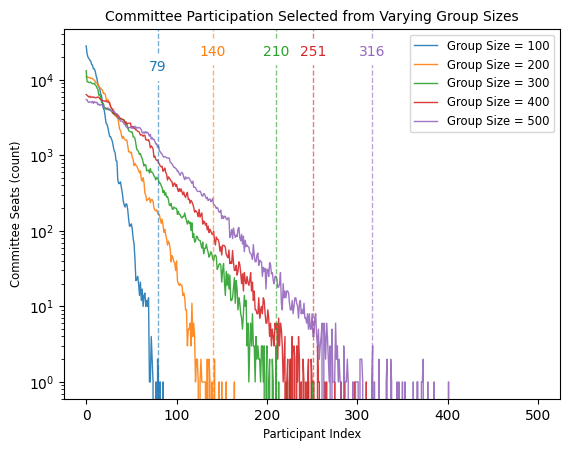

In [ ]:
# %%

# Plot the selection counts for each group size with log scale
log_scale = True
plot_committee_selection_counts(
    selection_counts,
    first_zero_indices,
    log_scale=log_scale,
)

 With the log scale you can see that the distribution of committee seats
 is uneven, with some participants getting selected multiple times while
 others are not selected at all.

 The cutoff stake value is the stake weight of the participant where the
 committee seat count first goes to zero. This is the point where the
 pigeonhole principle applies, showing that some participants with smaller
 stake weights may not get selected for committee seats.

 This is expected due to the variation in
 stake weights. The pigeonhole principle helps us understand this
 uneven distribution of selections based on stake weights.